In [11]:
!pip install opendatasets -q
import opendatasets as od
od.download('http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip')
!unzip '/content/BCICIV_1_mat.zip'

Using downloaded and verified file: ./BCICIV_1_mat.zip
Archive:  /content/BCICIV_1_mat.zip
replace BCICIV_calib_ds1a.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [12]:
import numpy as np
import scipy.io
from matplotlib import mlab
import matplotlib.pyplot as plt
import scipy.signal
from numpy import linalg

In [351]:
m = scipy.io.loadmat('/content/BCICIV_calib_ds1g.mat', struct_as_record=True) # load data from matlab file

#get informtion
sample_rate = m['nfo']['fs'][0][0][0][0] #sample rate
EEG = m['cnt'].T # the EEG signal
nchannels, nsamples = EEG.shape # num of channels and num of sample 

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]] # channel names
event_onsets = m['mrk'][0][0][0] # start of every event
event_codes = m['mrk'][0][0][1] # event codes

# get labels
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

# get classes
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [352]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', nevents)
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190602)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [353]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

In [354]:
# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

In [355]:
# (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [356]:
# Calculates for each trial the Power Spectral Density (PSD).
def psd(trials):
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [357]:
psd_l, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_f}

In [358]:
# Plots PSD data calculated with psd().
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    
    plt.figure(figsize=(20,8))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # x-axis limit
        plt.xlim(1,30)
        
        # y-axis limit
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        # titles for plots
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

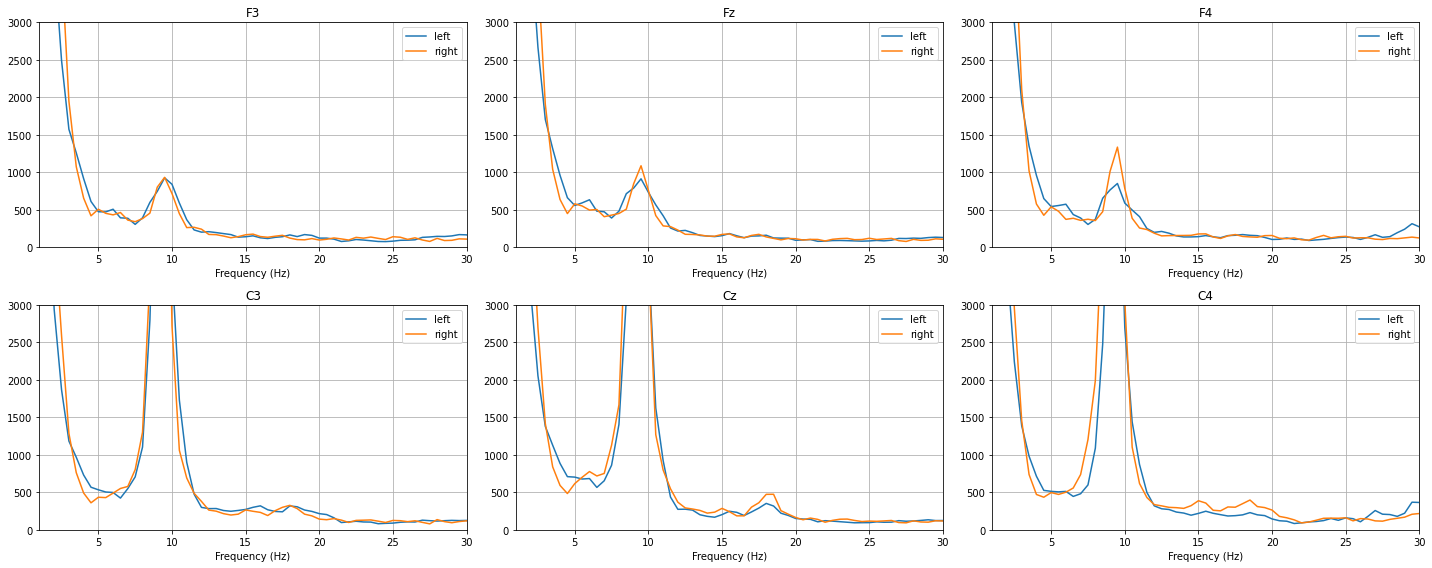

In [359]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['F3', 'Fz', 'F4','C3', 'Cz', 'C4']],
    chan_lab=['F3', 'Fz', 'F4','C3', 'Cz', 'C4'],
    maxy=3000
)

In [360]:
# Designs and applies a bandpass filter to the signal.
def bandpass(trials, lo, hi, sample_rate):
  
    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [361]:
# strip away frequencies outside the 8--15Hz window (Beta)
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

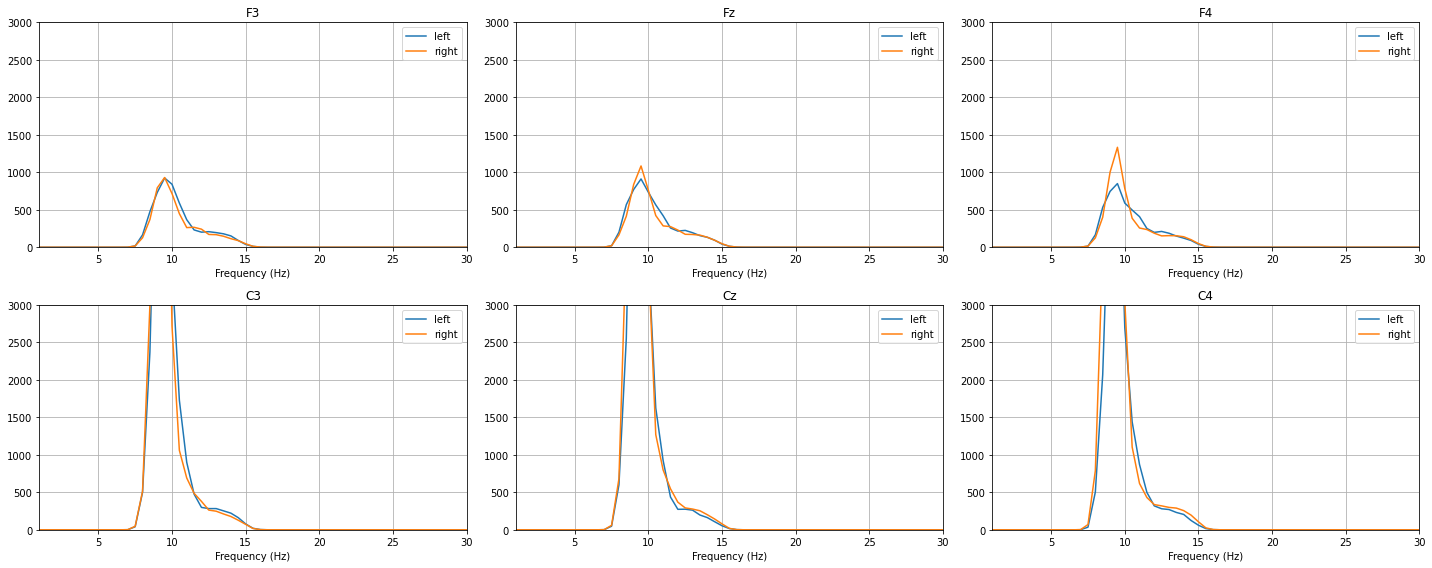

In [362]:
# Plotting the PSD of the resulting trials_filt
psd_l, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['F3', 'Fz', 'F4','C3', 'Cz', 'C4']],
    chan_lab=['F3', 'Fz', 'F4','C3', 'Cz', 'C4'],
    maxy=3000
)

In [363]:
# Calculate the log(var) of the trials
def logvar(trials):
  
    return np.log(np.var(trials, axis=1))

In [364]:
# we will use the logarithm of the variance of each channel as a feature for the classifier
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}

In [365]:
# Plots the log-var of each channel/component.
def plot_logvar(trials):

    plt.figure(figsize=(20,6))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

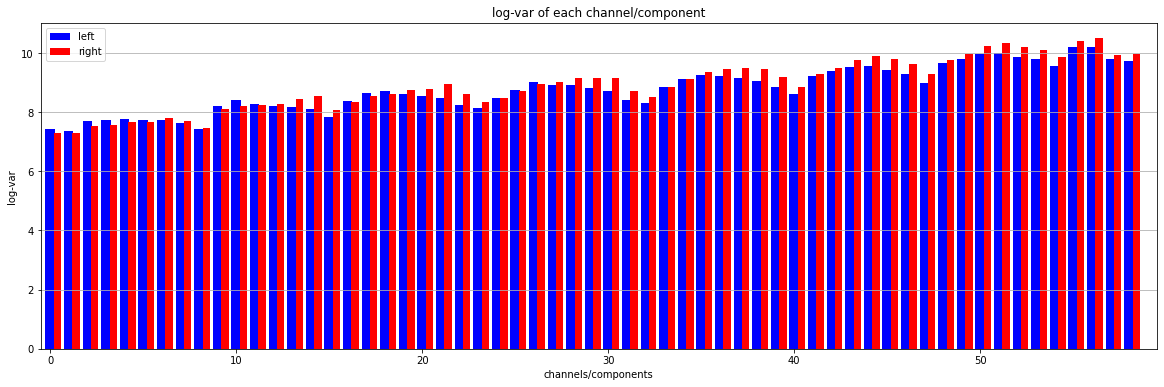

In [366]:
# Plot the log-vars
plot_logvar(trials_logvar)

In [367]:
# Calculate the covariance for each trial and return their average 
def cov(trials):
    
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

In [368]:
# Calculate a whitening matrix for covariance matrix sigma. 
def whitening(sigma):
    
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

In [369]:
# Calculate the CSP transformation matrix W.
def csp(trials_r, trials_f):
  
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

In [370]:
# Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)
def apply_mix(W, trials):
    
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [371]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

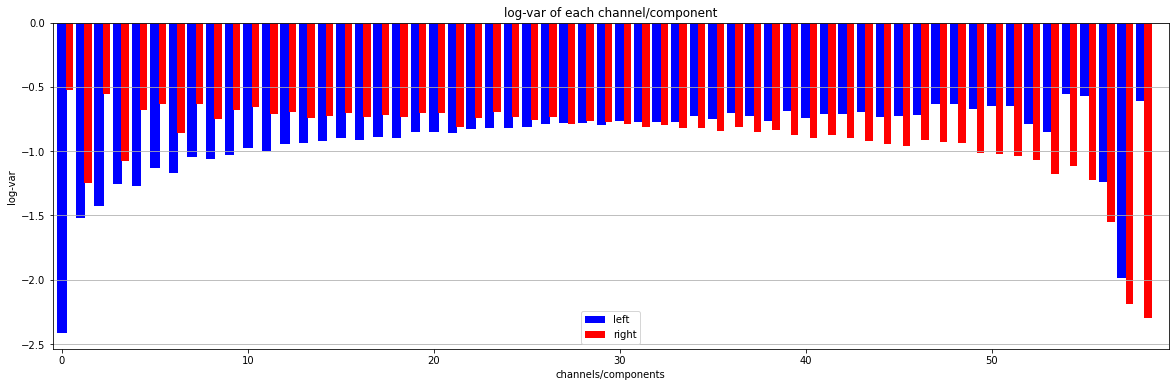

In [372]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

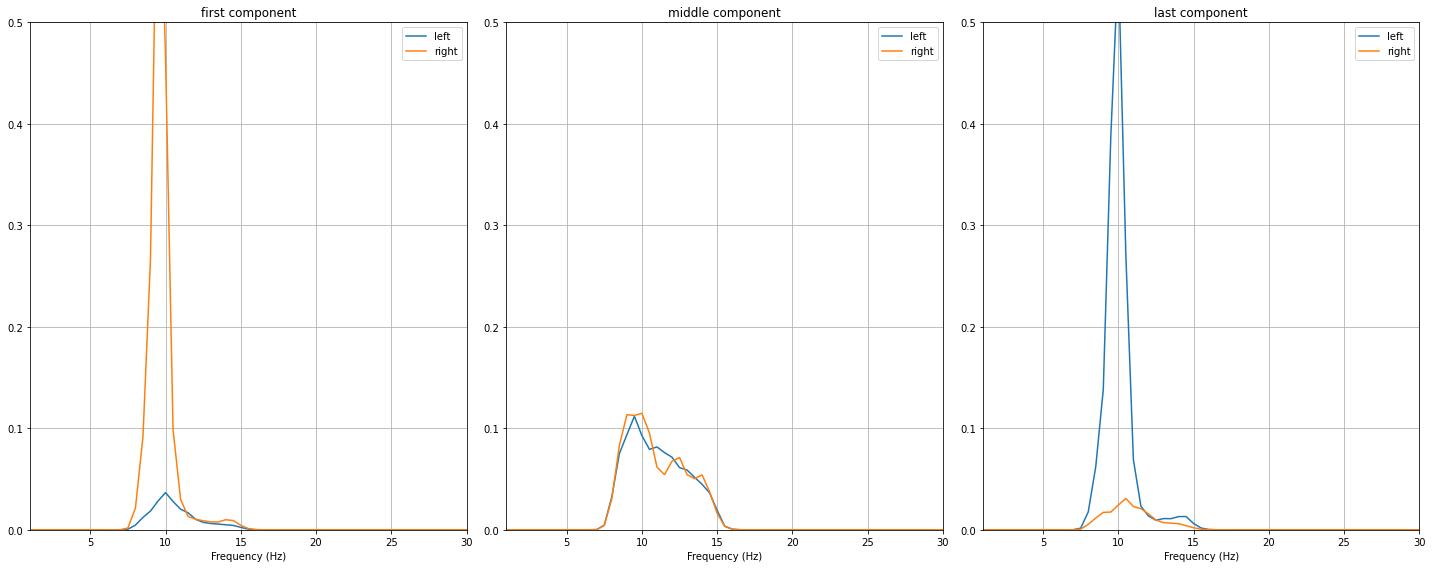

In [373]:
# plots the PSD for the first and last components as well as one in the middle
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_r,
              cl2: psd_f}

plot_psd(trials_PSD,
         freqs,
         [0,28,-1],
         chan_lab=['first component', 'middle component', 'last component'],
         maxy=0.5 )

In [374]:
# a scatter plot to see differentiate between the two classes
def plot_scatter(cl1, cl2):
    plt.figure()
    plt.scatter(cl1[0,:], cl1[-1,:], color='b')
    plt.scatter(cl2[0,:], cl2[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

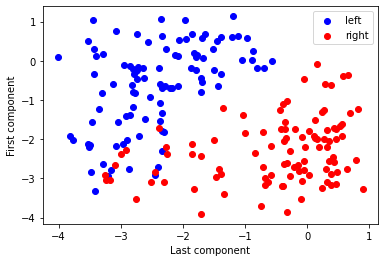

In [375]:
# the x-axis is the first CSP component, the y-axis is the last
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [376]:
# Percentage of trials to use for training (80-20 split here)
train_percentage = 0.8 

# Calculate the number of trials for each class the above percentage boils down to
ntrain_l = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_l
ntest_f = trials_filt[cl2].shape[2] - ntrain_f

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_l],
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_l:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

# Select only the first and last components for classification 
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [377]:
# the LDA algorithm
def train_lda(class1, class2):

    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    

    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

In [378]:
# function predict new data.
def predict_lda(test, W, b):
  
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):

        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [379]:
# train the model
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [ 3.54614573 -3.27647797]
b: -0.43251864689564457


<Figure size 1440x1440 with 0 Axes>

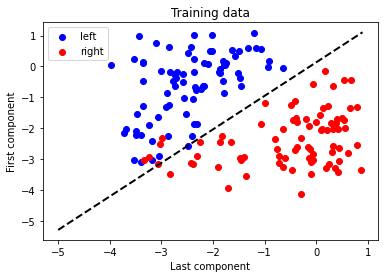

In [380]:
# Scatterplot
plt.figure(figsize=(20,20))
plot_scatter(train[cl1], train[cl2])
plt.title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')


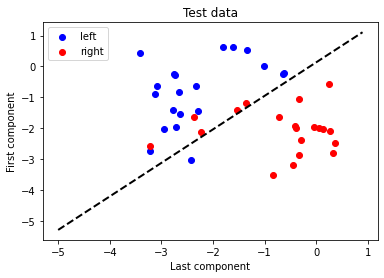

In [381]:
plot_scatter(test[cl1], test[cl2])
plt.title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')

In [382]:
# Print confusion matrix for train data
conf = np.array([
    [(predict_lda(train[cl1], W, b) == 1).sum(), (predict_lda(train[cl2], W, b) == 1).sum()],
    [(predict_lda(train[cl1], W, b) == 2).sum(), (predict_lda(train[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.4f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[80  5]
 [ 0 75]]

Accuracy: 0.9688


In [383]:
# Print confusion matrix for train data
conf = np.array([
    [(predict_lda(test[cl1], W, b) == 1).sum(), (predict_lda(test[cl2], W, b) == 1).sum()],
    [(predict_lda(test[cl1], W, b) == 2).sum(), (predict_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.4f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[19  5]
 [ 1 15]]

Accuracy: 0.8500
